# Finetuning example - peculiar galaxies

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!nvidia-smi

Thu Dec 21 17:56:28 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Load Zoobot and necessary modules

In [ ]:
!git clone https://github.com/mwalmsley/zoobot.git

Cloning into 'zoobot'...
remote: Enumerating objects: 9909, done.
remote: Counting objects: 100% (3897/3897), done.
remote: Compressing objects: 100% (1060/1060), done.
remote: Total 9909 (delta 2871), reused 3840 (delta 2827), pack-reused 6012
Receiving objects: 100% (9909/9909), 334.34 MiB | 20.12 MiB/s, done.
Resolving deltas: 100% (6462/6462), done.


In [ ]:
!pip install -e /content/zoobot[tensorflow]

Obtaining file:///content/zoobot
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install matplotlib_scalebar

In [ ]:
import os
import logging
import json
import glob
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tqdm import tqdm
%load_ext tensorboard
from sklearn import metrics
import seaborn as sns
from matplotlib_scalebar.scalebar import ScaleBar

In [ ]:
import sys
sys.path.insert(0,'/content/zoobot')

#from zoobot.shared import label_metadata, schemas
from zoobot.tensorflow.estimators import define_model, custom_layers
from zoobot.tensorflow.predictions import predict_on_dataset
from zoobot.tensorflow.training import training_config, losses, finetune
from galaxy_datasets.tensorflow import get_image_dataset, add_transforms_to_dataset
from galaxy_datasets.transforms import default_transforms

In [ ]:
device_name = tf.test.gpu_device_name()
print("Device Name:",device_name)

In [ ]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

## Create datasets

### Load images

In [ ]:
#Parameters
initial_size, resize_size, file_format = 300, 224, "jpg"
batch_size = 32

In [ ]:
#Copy the jpgs from Google Drive
!cp /content/drive/MyDrive/MPE/ZoobotEuclid/Data/Euclidized_COSMOS_complete/jpgs_euclid_complete.zip /content/
!unzip jpgs_euclid_complete.zip

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: jpgs_euclid_complete/20057247.jpg  
  inflating: jpgs_euclid_complete/20196205.jpg  
  inflating: jpgs_euclid_complete/20110801.jpg  
  inflating: jpgs_euclid_complete/20115629.jpg  
  inflating: jpgs_euclid_complete/20128307.jpg  
  inflating: jpgs_euclid_complete/20100342.jpg  
  inflating: jpgs_euclid_complete/20154824.jpg  
  inflating: jpgs_euclid_complete/20023681.jpg  
  inflating: jpgs_euclid_complete/20116543.jpg  
  inflating: jpgs_euclid_complete/20101099.jpg  
  inflating: jpgs_euclid_complete/20014114.jpg  
  inflating: jpgs_euclid_complete/20135187.jpg  
  inflating: jpgs_euclid_complete/20005213.jpg  
  inflating: jpgs_euclid_complete/20122447.jpg  
  inflating: jpgs_euclid_complete/20108397.jpg  
  inflating: jpgs_euclid_complete/20017676.jpg  
  inflating: jpgs_euclid_complete/20208664.jpg  
  inflating: jpgs_euclid_complete/20177285.jpg  
  inflating: jpgs_euclid_complete/20053271.jpg  
  

### Prepare dataset

In [ ]:
def check_for_images(paths):
    """
        Check if images are present and remove non-existing images.
    """
    print("There are labels for",len(paths),"images.")
    print("Checking if the files exist...")
    ids_checked= []
    for i in tqdm(range(len(paths))):
        file_exists = os.path.exists(paths[i])
        if file_exists:
            ids_checked.append(paths[i].split("/")[-1].split(".")[0])
    print("\nCheck over. There are actually",len(ids_checked),"images.")
    return ids_checked

In [ ]:
labels = pd.read_csv("/content/drive/MyDrive/MPE/ZoobotEuclid/Data/EuclidZoo_aggregated_Oct2021_with_labels.csv")
labels

,Filename,ObjectID,#recno,#Survey,RA,DEC,#f1,#Nf1,#f2,#Nf2,...,N_gravitational_lens,N_irregular,N_spheroid2,p_spheroid,p_disc,p_irregular,spheroid,disc,irregular,total
0,20147936_arcsinh_filter.png,20147936,210287,1447333,150.109354,2.590302,814,1,0,0,...,0,0,2,0.5,0.5,0.0,0.0,1.0,0.0,1.0
1,20016225_arcsinh_filter.png,20016225,85435,361838,150.007071,1.720840,814,1,0,0,...,0,0,1,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,20130337_arcsinh_filter.png,20130337,193666,1303194,149.627751,2.396173,814,1,0,0,...,0,0,1,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,20042818_arcsinh_filter.png,20042818,110788,588446,149.921210,1.829432,814,1,0,0,...,0,0,1,0.5,0.5,0.0,0.0,1.0,0.0,1.0
4,20092890_arcsinh_filter.png,20092890,158461,825411,149.994988,2.238617,814,2,0,0,...,0,0,4,0.8,0.2,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2001,20042706_arcsinh_filter.png,20042706,110680,812318,150.052721,1.860457,814,1,0,0,...,0,0,2,0.5,0.5,0.0,0.0,1.0,0.0,1.0
2002,20118553_arcsinh_filter.png,20118553,182783,831517,150.140348,2.418957,814,1,0,0,...,0,0,2,0.5,0.5,0.0,0.0,1.0,0.0,1.0
2003,20094646_arcsinh_filter.png,20094646,160134,1037787,149.988972,2.170531,814,2,0,0,...,0,0,2,0.5,0.5,0.0,0.0,1.0,0.0,1.0
2004,20150744_arcsinh_filter.png,20150744,212958,1470421,150.048990,2.598849,814,2,0,0,...,0,0,3,0.5,0.5,0.0,0.0,1.0,0.0,1.0


In [ ]:
objNos = list(labels["ObjectID"])
paths = ["/content/jpgs_euclid_complete/" + str(name) +".jpg" for name in objNos]
ids_checked = check_for_images(paths)
path_checked = ["/content/jpgs_euclid_complete/" + str(name) +".jpg" for name in ids_checked]

labels_checked = labels[labels["ObjectID"].astype(str).isin(ids_checked)]
labels_checked["id_str"] = path_checked
labels_checked["survey_id"] = labels_checked["ObjectID"]
labels_checked

There are labels for 2006 images.
Checking if the files exist...


100%|██████████| 2006/2006 [00:00<00:00, 125492.55it/s]


Check over. There are actually 2006 images.


,Filename,ObjectID,#recno,#Survey,RA,DEC,#f1,#Nf1,#f2,#Nf2,...,N_spheroid2,p_spheroid,p_disc,p_irregular,spheroid,disc,irregular,total,id_str,survey_id
0,20147936_arcsinh_filter.png,20147936,210287,1447333,150.109354,2.590302,814,1,0,0,...,2,0.5,0.5,0.0,0.0,1.0,0.0,1.0,/content/jpgs_euclid_complete/20147936.jpg,20147936
1,20016225_arcsinh_filter.png,20016225,85435,361838,150.007071,1.720840,814,1,0,0,...,1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,/content/jpgs_euclid_complete/20016225.jpg,20016225
2,20130337_arcsinh_filter.png,20130337,193666,1303194,149.627751,2.396173,814,1,0,0,...,1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,/content/jpgs_euclid_complete/20130337.jpg,20130337
3,20042818_arcsinh_filter.png,20042818,110788,588446,149.921210,1.829432,814,1,0,0,...,1,0.5,0.5,0.0,0.0,1.0,0.0,1.0,/content/jpgs_euclid_complete/20042818.jpg,20042818
4,20092890_arcsinh_filter.png,20092890,158461,825411,149.994988,2.238617,814,2,0,0,...,4,0.8,0.2,0.0,1.0,0.0,0.0,1.0,/content/jpgs_euclid_complete/20092890.jpg,20092890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2001,20042706_arcsinh_filter.png,20042706,110680,812318,150.052721,1.860457,814,1,0,0,...,2,0.5,0.5,0.0,0.0,1.0,0.0,1.0,/content/jpgs_euclid_complete/20042706.jpg,20042706
2002,20118553_arcsinh_filter.png,20118553,182783,831517,150.140348,2.418957,814,1,0,0,...,2,0.5,0.5,0.0,0.0,1.0,0.0,1.0,/content/jpgs_euclid_complete/20118553.jpg,20118553
2003,20094646_arcsinh_filter.png,20094646,160134,1037787,149.988972,2.170531,814,2,0,0,...,2,0.5,0.5,0.0,0.0,1.0,0.0,1.0,/content/jpgs_euclid_complete/20094646.jpg,20094646
2004,20150744_arcsinh_filter.png,20150744,212958,1470421,150.048990,2.598849,814,2,0,0,...,3,0.5,0.5,0.0,0.0,1.0,0.0,1.0,/content/jpgs_euclid_complete/20150744.jpg,20150744


In [ ]:
labels_peculiar = labels_checked[["survey_id","id_str","N_classifications","N_peculiar"]]
labels_peculiar[0:10]

,survey_id,id_str,N_classifications,N_peculiar
0,20147936,/content/jpgs_euclid_complete/20147936.jpg,3,0
1,20016225,/content/jpgs_euclid_complete/20016225.jpg,1,0
2,20130337,/content/jpgs_euclid_complete/20130337.jpg,1,0
3,20042818,/content/jpgs_euclid_complete/20042818.jpg,1,0
4,20092890,/content/jpgs_euclid_complete/20092890.jpg,3,0
5,20135162,/content/jpgs_euclid_complete/20135162.jpg,1,0
6,20141876,/content/jpgs_euclid_complete/20141876.jpg,3,0
7,20118227,/content/jpgs_euclid_complete/20118227.jpg,3,2
8,20084139,/content/jpgs_euclid_complete/20084139.jpg,2,1
9,20142919,/content/jpgs_euclid_complete/20142919.jpg,2,0


In [ ]:
class_thresh = 0.5
labels_peculiar["peculiar_frac"] = labels_peculiar["N_peculiar"]/labels_peculiar["N_classifications"]
labels_peculiar["peculiar"] = (labels_peculiar["peculiar_frac"] >= class_thresh)
labels_peculiar[0:10]

,survey_id,id_str,N_classifications,N_peculiar,peculiar_frac,peculiar
0,20147936,/content/jpgs_euclid_complete/20147936.jpg,3,0,0.000000,False
1,20016225,/content/jpgs_euclid_complete/20016225.jpg,1,0,0.000000,False
2,20130337,/content/jpgs_euclid_complete/20130337.jpg,1,0,0.000000,False
3,20042818,/content/jpgs_euclid_complete/20042818.jpg,1,0,0.000000,False
4,20092890,/content/jpgs_euclid_complete/20092890.jpg,3,0,0.000000,False
5,20135162,/content/jpgs_euclid_complete/20135162.jpg,1,0,0.000000,False
6,20141876,/content/jpgs_euclid_complete/20141876.jpg,3,0,0.000000,False
7,20118227,/content/jpgs_euclid_complete/20118227.jpg,3,2,0.666667,True
8,20084139,/content/jpgs_euclid_complete/20084139.jpg,2,1,0.500000,True
9,20142919,/content/jpgs_euclid_complete/20142919.jpg,2,0,0.000000,False


In [ ]:
#Balance dataset
#filenames_peculiar = list(labels_peculiar[labels_peculiar["peculiar"]]["id_str"])
#filenames_not_peculiar = list(labels_peculiar[labels_peculiar["peculiar"]==False]["id_str"])
#filenames_not_peculiar_balance = []
#for i in range(len(labels_peculiar[labels_peculiar["peculiar"]])):
#    random_index = np.random.randint(len(filenames_not_peculiar)-1)
#    filenames_not_peculiar_balance.append(filenames_not_peculiar[random_index])
#    filenames_not_peculiar.pop(random_index)
#    filenames_balanced = filenames_peculiar + filenames_not_peculiar_balance
#labels_peculiar = labels_peculiar[labels_peculiar["id_str"].isin(filenames_balanced)]

In [ ]:
#labels_peculiar.to_csv("/content/drive/MyDrive/MPE/ZoobotEuclid/Data/peculiar_labels.csv",index=False)

In [ ]:
metadata = pd.read_csv("/content/drive/MyDrive/MPE/ZoobotEuclid/Data/metadata_main.csv")
labels_peculiar = pd.merge(labels_peculiar,metadata,on="survey_id")

<ipython-input-74-39700471c16b>:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv("/content/drive/MyDrive/MPE/ZoobotEuclid/Data/metadata_main.csv")


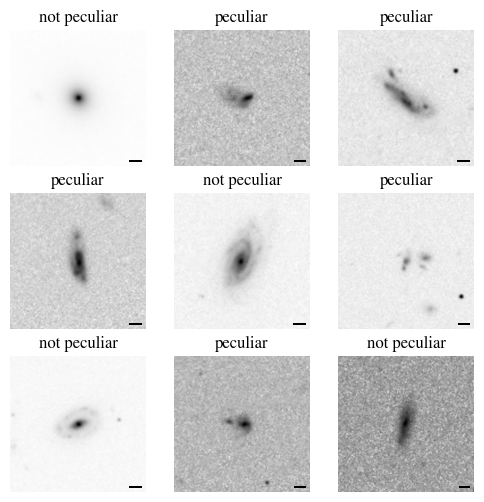

In [ ]:
indices = [90,71,102,303,96,7,86,57,80]

#Plot examples
class_names = ["not peculiar","peculiar"]
fig, ax = plt.subplots(3,3,figsize=(6,6))
ax = ax.flatten()
for i in range(len(ax)):
    index = indices[i]
    image = np.asarray(ImageOps.invert(Image.open(labels_peculiar["id_str"].iloc[index])))
    image_size = float(3*labels_peculiar["KRON_RADIUS_HI"].iloc[index])
    resolution = image_size/300
    scalebar = ScaleBar(resolution,units="''",dimension="angle",color="black",frameon=False,location="lower right",label_loc="none",scale_loc="none",fixed_value=1)
    ax[i].imshow(image)
    ax[i].axis("off")
    ax[i].add_artist(scalebar)
    ax[i].set_title("{}".format(class_names[labels_peculiar["peculiar"].astype(int).iloc[index]]))
plt.savefig("/content/drive/MyDrive/MPE/ZoobotEuclid/Results/plots/peculiar_labels_examples.pdf",bbox_inches='tight')

In [ ]:
print("From the {} labelled galaxies are {} peculiar and {} not."\
      .format(len(labels_peculiar),len(labels_peculiar[labels_peculiar["peculiar"]]),len(labels_peculiar[labels_peculiar["peculiar"]==False])))

From the 2006 labelled galaxies are 231 peculiar and 1775 not.


### Create training, validation and test sets

In [ ]:
#Split dataset into train, val and test sets
train_catalog, hidden_catalog = train_test_split(labels_peculiar, train_size=0.7)
val_catalog, test_catalog = train_test_split(hidden_catalog, train_size=1./3.)

print("70%/10%/20% split: {} galaxies for training, {} for validation, {} for testing".format(len(train_catalog),len(val_catalog),len(test_catalog)))

70%/10%/20% split: 1404 galaxies for training, 200 for validation, 402 for testing


In [ ]:
#Balance training set
filenames_peculiar = list(train_catalog[train_catalog["peculiar"]]["id_str"])
filenames_not_peculiar = list(train_catalog[train_catalog["peculiar"]==False]["id_str"])
filenames_not_peculiar_balance = []
for i in range(len(train_catalog[train_catalog["peculiar"]])):
    random_index = np.random.randint(len(filenames_not_peculiar)-1)
    filenames_not_peculiar_balance.append(filenames_not_peculiar[random_index])
    filenames_not_peculiar.pop(random_index)
filenames_balanced = filenames_peculiar + filenames_not_peculiar_balance
train_catalog = train_catalog[train_catalog["id_str"].isin(filenames_balanced)]

In [ ]:
#Balance validation set
filenames_peculiar = list(val_catalog[val_catalog["peculiar"]]["id_str"])
filenames_not_peculiar = list(val_catalog[val_catalog["peculiar"]==False]["id_str"])
filenames_not_peculiar_balance = []
for i in range(len(val_catalog[val_catalog["peculiar"]])):
    random_index = np.random.randint(len(filenames_not_peculiar)-1)
    filenames_not_peculiar_balance.append(filenames_not_peculiar[random_index])
    filenames_not_peculiar.pop(random_index)
filenames_balanced = filenames_peculiar + filenames_not_peculiar_balance
val_catalog = val_catalog[val_catalog["id_str"].isin(filenames_balanced)]

In [ ]:
print("70%/10%/20% split: {} galaxies for training, {} for validation, {} for testing".format(len(train_catalog),len(val_catalog),len(test_catalog)))

70%/10%/20% split: 308 galaxies for training, 54 for validation, 402 for testing


In [ ]:
#Extract image paths and labels
train_image_paths, train_labels = np.array(train_catalog["id_str"]), np.array(train_catalog["peculiar"])
val_image_paths, val_labels = np.array(val_catalog["id_str"]), np.array(val_catalog["peculiar"])
test_image_paths, test_labels = np.array(test_catalog["id_str"]), np.array(test_catalog["peculiar"])

#Create datasets
train_dataset = get_image_dataset(train_image_paths,requested_img_size=initial_size, labels=train_labels,greyscale=True)
val_dataset = get_image_dataset(val_image_paths,requested_img_size=initial_size, labels=val_labels,greyscale=True)
test_dataset = get_image_dataset(test_image_paths,requested_img_size=initial_size, labels=test_labels,greyscale=True)

#Apply transformations (resizing)
transforms = default_transforms(crop_scale_bounds=(1,1),crop_ratio_bounds=(1, 1),resize_after_crop=initial_size)
train_dataset = add_transforms_to_dataset(train_dataset, transforms)
val_dataset = add_transforms_to_dataset(val_dataset, transforms)
test_dataset = add_transforms_to_dataset(test_dataset, transforms)

#Batch, shuffle, prefetch
train_dataset = train_dataset.shuffle(5000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)

## Prepare model

In [ ]:
#Load ZoobotEuclid model and weights
checkpoint_loc = "/content/drive/MyDrive/MPE/ZoobotEuclid/Results/euclid/complete/weights_D/num_galaxies_60940/checkpoint"

base_model = define_model.get_model(input_size=initial_size,channels=1,dropout_rate=0.2,include_top=False,output_dim=None)
euclid_head = tf.keras.Sequential([
        layers.InputLayer(input_shape=(1280)),
        layers.Dense(40, activation=lambda x: tf.nn.sigmoid(x) * 100. + 1.)
])

model = tf.keras.Sequential([
    base_model,
    euclid_head
])
model.load_weights(checkpoint_loc)

model_base = model.layers[:-1].pop()
model_base.summary()

model_base.trainable = False

Model: "zoobot"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocessed_image_batch (I  [(None, 300, 300, 1)]    0         
 nputLayer)                                                      
                                                                 
 log_image_16 (LogImage)     (None, 300, 300, 1)       0         
                                                                 
 headless_efficientnet (Sequ  (None, 1280)             4048988   
 ential)                                                         
                                                                 
 log_histogram_16 (LogHistog  (None, 1280)             0         
 ram)                                                            
                                                                 
Total params: 4,048,988
Trainable params: 4,006,972
Non-trainable params: 42,016
_____________________________________________

In [ ]:
#Create new head
new_head = tf.keras.Sequential([
    layers.InputLayer(input_shape=(1280)),
    layers.Dense(1, activation="sigmoid", name='sigmoid_output')
])

#Stick new head to model
model = tf.keras.Sequential([
    model_base,
    new_head
])

model.summary()

Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zoobot (Functional)         (None, 1280)              4048988   
                                                                 
 sequential_66 (Sequential)  (None, 1)                 1281      
                                                                 
Total params: 4,050,269
Trainable params: 1,281
Non-trainable params: 4,048,988
_________________________________________________________________


## Train model

In [ ]:
save_path = "/content/zoobot_save/"
model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=['accuracy'])
trainer = training_config.Trainer(log_dir=save_path, epochs=200, patience=20)
print("Training head:")
trained_model = trainer.fit(model, train_dataset, val_dataset)

#One could unfreeze more/all layers of the model for training
#finetune.unfreeze_model(trained_model, unfreeze_names=[], unfreeze_all=True)
#finetune.unfreeze_model(model, unfreeze_names=['top', 'block7'])
#trained_model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),metrics=['accuracy'])
#trained_model = trainer.fit(trained_model, train_dataset, val_dataset)

Training head:
Epoch 1/200


10/10 - 17s - loss: 0.6864 - accuracy: 0.5649 - val_loss: 0.6762 - val_accuracy: 0.7593 - 17s/epoch - 2s/step
Epoch 2/200
10/10 - 3s - loss: 0.6738 - accuracy: 0.7955 - val_loss: 0.6631 - val_accuracy: 0.8519 - 3s/epoch - 269ms/step
Epoch 3/200
10/10 - 3s - loss: 0.6630 - accuracy: 0.7987 - val_loss: 0.6501 - val_accuracy: 0.8519 - 3s/epoch - 268ms/step
Epoch 4/200
10/10 - 4s - loss: 0.6524 - accuracy: 0.8052 - val_loss: 0.6389 - val_accuracy: 0.8333 - 4s/epoch - 379ms/step
Epoch 5/200
10/10 - 4s - loss: 0.6410 - accuracy: 0.8052 - val_loss: 0.6307 - val_accuracy: 0.8519 - 4s/epoch - 410ms/step
Epoch 6/200
10/10 - 4s - loss: 0.6331 - accuracy: 0.8182 - val_loss: 0.6223 - val_accuracy: 0.8519 - 4s/epoch - 354ms/step
Epoch 7/200
10/10 - 3s - loss: 0.6247 - accuracy: 0.8084 - val_loss: 0.6068 - val_accuracy: 0.8519 - 3s/epoch - 266ms/step
Epoch 8/200
10/10 - 3s - loss: 0.6132 - accuracy: 0.8344 - val_loss: 0.5956 - val_accuracy: 0.8704 - 3s/epoch - 260ms/step
Epoch 9/200
10/10 - 3s - loss

## Make predictions

In [ ]:
prediction_dataset = get_image_dataset(test_image_paths, include_id_str=True, labels=None, requested_img_size=initial_size, greyscale=True)
prediction_dataset = prediction_dataset.batch(32, drop_remainder=False)
predict_on_dataset.predict(prediction_dataset, trained_model, n_samples=1, label_cols=["peculiar"], save_loc="/content/drive/MyDrive/MPE/ZoobotEuclid/Results/peculiar_predictions.csv")

13/13 [==============================] - 3s 115ms/step


## Analyze predictions

In [ ]:
prediction_data = pd.read_csv("/content/drive/MyDrive/MPE/ZoobotEuclid/Results/peculiar_predictions.csv")
prediction_data["peculiar_pred_frac"] = prediction_data["peculiar_pred"]
prediction_data["peculiar_pred_075"] = (prediction_data["peculiar_pred_frac"] >= 0.75)
prediction_data["peculiar_pred_050"] = (prediction_data["peculiar_pred_frac"] >= 0.5)
prediction_data = pd.merge(prediction_data,labels_peculiar,on="id_str")
prediction_data = prediction_data.sort_values("peculiar_frac",ascending=False)
prediction_data

,id_str,peculiar_pred,peculiar_pred_frac,peculiar_pred_075,peculiar_pred_050,N_classifications,N_peculiar,peculiar_frac,peculiar
0,/content/jpgs_euclid_complete/20122242.jpg,0.674112,0.674112,False,True,1,1,1.0,True
68,/content/jpgs_euclid_complete/20086084.jpg,0.946359,0.946359,True,True,1,1,1.0,True
189,/content/jpgs_euclid_complete/20038938.jpg,0.940218,0.940218,True,True,1,1,1.0,True
246,/content/jpgs_euclid_complete/20108731.jpg,0.907275,0.907275,True,True,2,2,1.0,True
250,/content/jpgs_euclid_complete/20016890.jpg,0.464037,0.464037,False,False,1,1,1.0,True
...,...,...,...,...,...,...,...,...,...
143,/content/jpgs_euclid_complete/20169401.jpg,0.284191,0.284191,False,False,1,0,0.0,False
142,/content/jpgs_euclid_complete/20053397.jpg,0.411028,0.411028,False,False,3,0,0.0,False
141,/content/jpgs_euclid_complete/20119504.jpg,0.067790,0.067790,False,False,3,0,0.0,False
140,/content/jpgs_euclid_complete/20112480.jpg,0.503106,0.503106,False,True,1,0,0.0,False


In [ ]:
def cm_peculiar(data,column_pred):
    labels, predictions = np.array(prediction_data["peculiar"]), np.array(prediction_data[column_pred])
    cm_abs = metrics.confusion_matrix(labels, predictions, normalize=None,labels=[True,False]).transpose()
    cm = metrics.confusion_matrix(labels, predictions, normalize="true",labels=[True,False]).transpose()
    labels_txt = []
    for j in range(len(cm)):
        labels_row = []
        for k in range(len(cm[j])):
            label = "{:.1%}".format(cm[j,k])+"\n"+"({})".format(cm_abs[j,k])
            labels_row.append(label)
        labels_txt.append(labels_row)
    #Metrics (with weighted option: metrics for both classes averaged)
    print("N: {}, accuracy: {:.2%}, precision: {:.2%}, recall: {:.2%}, F1: {:.2%}, F1-w: {:.2%}".format(len(labels),
        metrics.accuracy_score(labels, predictions),
        metrics.precision_score(labels, predictions, average="macro"),
        metrics.recall_score(labels, predictions, average="macro"),
        metrics.f1_score(labels, predictions, average="macro"),
        metrics.f1_score(labels, predictions, average="weighted")))
    return cm, labels_txt

N: 402, accuracy: 79.10%, precision: 66.96%, recall: 82.92%, F1: 68.94%, F1-w: 82.29%
N: 402, accuracy: 91.54%, precision: 80.25%, recall: 82.30%, F1: 81.23%, F1-w: 91.68%


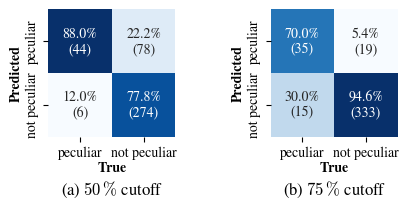

In [ ]:
#Confusion matrix
ticklabels = ["peculiar", "not peculiar"]
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(5,2.75))
fig.tight_layout(pad=4)
cm_50, label_names_50 = cm_peculiar(prediction_data,"peculiar_pred_050")
cm_75, label_names_75 = cm_peculiar(prediction_data,"peculiar_pred_075")
sns.heatmap(cm_50, annot=label_names_50,cmap='Blues',fmt="",xticklabels=ticklabels,yticklabels=ticklabels,ax=ax[0],cbar=False,square=True,robust=True)
ax[0].text(1,2.5, 'True', horizontalalignment='center', verticalalignment='center',weight='bold')
ax[0].text(-0.5,1, 'Predicted', rotation='vertical', horizontalalignment='center', verticalalignment='center',weight='bold')
ax[0].text(1,2.9, '(a) $50\,\%$ cutoff', horizontalalignment='center', fontsize="large")
sns.heatmap(cm_75, annot=label_names_75,cmap='Blues',fmt="",xticklabels=ticklabels,yticklabels=ticklabels,ax=ax[1],cbar=False,square=True,robust=True)
ax[1].text(1,2.5, 'True', horizontalalignment='center', verticalalignment='center',weight='bold')
ax[1].text(-0.5,1, 'Predicted', rotation='vertical', horizontalalignment='center', verticalalignment='center',weight='bold')
ax[1].text(1,2.9, '(b) $75\,\%$ cutoff', horizontalalignment='center', fontsize="large")
plt.savefig("/content/drive/MyDrive/MPE/ZoobotEuclid/Results/plots/peculiar_confusion_matrix.pdf",bbox_inches='tight')